# PCA Applications: Data Compression and Feature Extraction

**Author**: Nelson Masbayi

---

In this notebook, we explore practical applications of PCA, focusing on data compression and feature extraction for machine learning. We'll analyze trade-offs between compression ratio and quality, and demonstrate PCA's value in real-world scenarios.

## Table of Contents

1. [Data Compression with PCA](#data-compression-with-pca)
2. [Image Compression Analysis](#image-compression-analysis)
3. [Compression Quality Metrics](#compression-quality-metrics)
4. [Trade-off Analysis](#trade-off-analysis)
5. [Practical Compression Guidelines](#practical-compression-guidelines)

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_olivetti_faces, load_digits
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import sys
import os
import pickle
import time
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Add src directory to the path
sys.path.append('../src')
from visualization_utils import plot_reconstruction_analysis

# Set style for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 12

# Set random seed
np.random.seed(42)

print("✅ All imports successful!")
print("🎯 Ready for PCA compression analysis")

✅ All imports successful!
🎯 Ready for PCA compression analysis


## Data Compression with PCA

PCA enables lossy data compression by:
1. **Dimensionality reduction**: Keep only the most important components
2. **Information preservation**: Retain maximum variance with fewer dimensions
3. **Reconstruction**: Approximate original data from compressed representation

### Compression Pipeline
```
Original Data → PCA Transform → Reduced Data → Storage/Transmission → PCA Inverse → Reconstructed Data
```

In [2]:
# Define compression utility functions
def calculate_compression_ratio(original_shape, n_components):
    """
    Calculate the compression ratio for PCA.

    For PCA compression, we need to store:
    - Transformed data: n_samples × n_components
    - Components: n_components × n_features
    - Mean vector: n_features
    """
    n_samples, n_features = original_shape

    # Original data size
    original_size = n_samples * n_features

    # Compressed data size
    transformed_size = n_samples * n_components  # Transformed data
    components_size = n_components * n_features  # Principal components
    mean_size = n_features                       # Mean vector

    compressed_size = transformed_size + components_size + mean_size

    compression_ratio = original_size / compressed_size

    return compression_ratio, original_size, compressed_size

def calculate_quality_metrics(original, reconstructed):
    """
    Calculate various quality metrics for reconstruction.
    """
    # Mean Squared Error
    mse = mean_squared_error(original.flatten(), reconstructed.flatten())

    # Root Mean Squared Error
    rmse = np.sqrt(mse)

    # Peak Signal-to-Noise Ratio (PSNR)
    if mse == 0:
        psnr = float('inf')
    else:
        max_pixel = np.max(original)
        psnr = 20 * np.log10(max_pixel / rmse)

    # Structural Similarity (simplified version)
    # Correlation coefficient as a simple similarity measure
    correlation = np.corrcoef(original.flatten(), reconstructed.flatten())[0, 1]

    return {
        'mse': mse,
        'rmse': rmse,
        'psnr': psnr,
        'correlation': correlation
    }

def compress_and_reconstruct(data, n_components):
    """
    Compress data using PCA and reconstruct it.
    """
    # Fit PCA
    pca = PCA(n_components=n_components)

    # Transform (compress)
    start_time = time.time()
    compressed_data = pca.fit_transform(data)
    compression_time = time.time() - start_time

    # Inverse transform (reconstruct)
    start_time = time.time()
    reconstructed_data = pca.inverse_transform(compressed_data)
    reconstruction_time = time.time() - start_time

    return pca, compressed_data, reconstructed_data, compression_time, reconstruction_time

print("Compression utility functions defined!")
print("Functions available:")
print("• calculate_compression_ratio()")
print("• calculate_quality_metrics()")
print("• compress_and_reconstruct()")

Compression utility functions defined!
Functions available:
• calculate_compression_ratio()
• calculate_quality_metrics()
• compress_and_reconstruct()


## Image Compression Analysis

Let's start with face image compression using the Olivetti faces dataset:

Loading Olivetti Faces dataset for compression analysis...
Dataset loaded successfully!
Shape: (400, 4096)
Image dimensions: 64×64 pixels
Data range: [0.000, 1.000]

Dataset Statistics:
Number of samples: 400
Number of features: 4096
Memory usage: 6400.0 KB


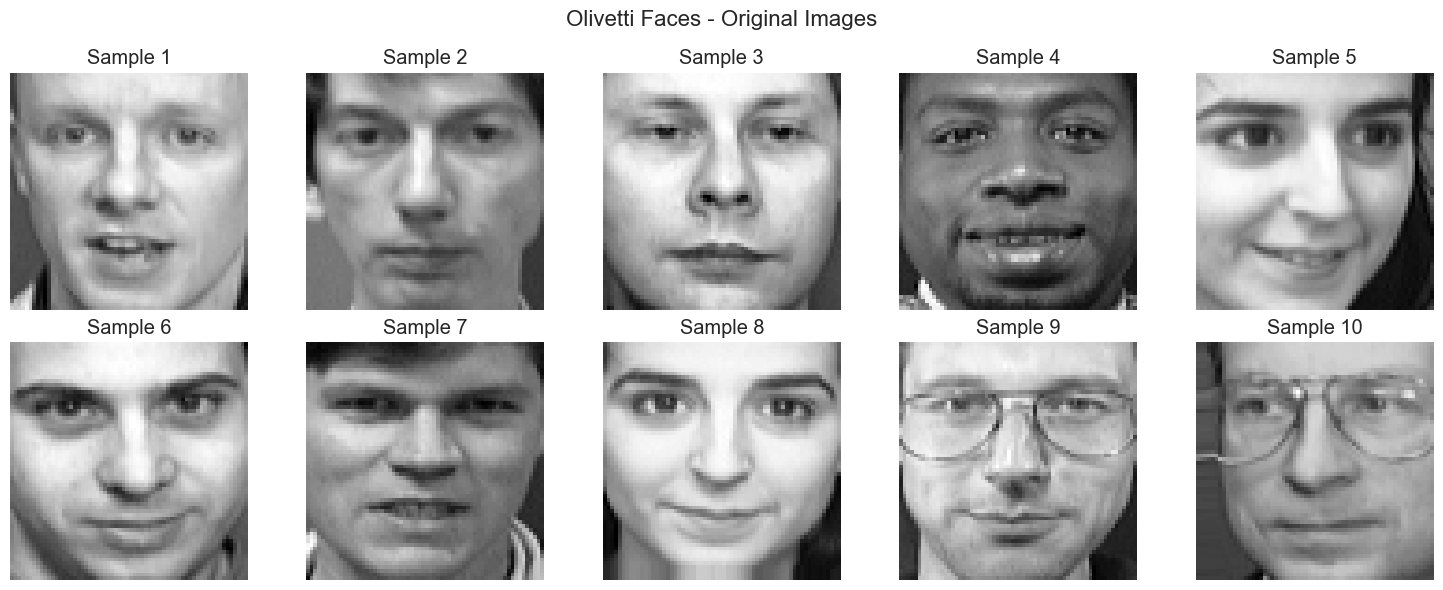

In [3]:
# Load face data
print("Loading Olivetti Faces dataset for compression analysis...")

try:
    faces = fetch_olivetti_faces(shuffle=True, random_state=42)
    X_faces = faces.data
    y_faces = faces.target

    print(f"Dataset loaded successfully!")
    print(f"Shape: {X_faces.shape}")
    print(f"Image dimensions: 64×64 pixels")
    print(f"Data range: [{X_faces.min():.3f}, {X_faces.max():.3f}]")

    faces_available = True

except Exception as e:
    print(f"Error loading faces: {e}")
    print("Using MNIST digits as backup for compression analysis")

    digits = load_digits()
    X_faces = digits.data
    y_faces = digits.target

    print(f"MNIST digits shape: {X_faces.shape}")
    print(f"Image dimensions: 8×8 pixels")

    faces_available = False

# Basic dataset statistics
print(f"\nDataset Statistics:")
print(f"Number of samples: {X_faces.shape[0]}")
print(f"Number of features: {X_faces.shape[1]}")
print(f"Memory usage: {X_faces.nbytes / 1024:.1f} KB")

# Display sample images
img_dim = 64 if faces_available else 8
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(10):
    image = X_faces[i].reshape(img_dim, img_dim)
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f'Sample {i+1}')
    axes[i].axis('off')

dataset_name = "Olivetti Faces" if faces_available else "MNIST Digits"
plt.suptitle(f'{dataset_name} - Original Images', fontsize=16)
plt.tight_layout()
plt.show()

In [4]:
# Comprehensive compression analysis
print("\n" + "="*60)
print("COMPREHENSIVE COMPRESSION ANALYSIS")
print("="*60)

# Define component ranges to test
if faces_available:
    component_ranges = [1, 2, 5, 10, 15, 20, 30, 40, 50, 75, 100, 150, 200]
else:
    component_ranges = [1, 2, 3, 5, 8, 10, 15, 20, 25, 30, 40, 50]

# Remove components that exceed feature count
max_components = min(X_faces.shape[1], X_faces.shape[0])
component_ranges = [c for c in component_ranges if c <= max_components]

print(f"Testing component ranges: {component_ranges}")
print(f"Maximum possible components: {max_components}")

# Storage for results
results = {
    'n_components': [],
    'compression_ratio': [],
    'variance_explained': [],
    'mse': [],
    'rmse': [],
    'psnr': [],
    'correlation': [],
    'compression_time': [],
    'reconstruction_time': [],
    'original_size': [],
    'compressed_size': []
}

print("\nProcessing compression analysis...")

for i, n_comp in enumerate(component_ranges):
    print(f"\rProcessing {n_comp} components ({i+1}/{len(component_ranges)})...", end='')

    # Compress and reconstruct
    pca, compressed, reconstructed, comp_time, recon_time = compress_and_reconstruct(X_faces, n_comp)

    # Calculate compression ratio
    comp_ratio, orig_size, comp_size = calculate_compression_ratio(X_faces.shape, n_comp)

    # Calculate quality metrics
    quality = calculate_quality_metrics(X_faces, reconstructed)

    # Store results
    results['n_components'].append(n_comp)
    results['compression_ratio'].append(comp_ratio)
    results['variance_explained'].append(np.sum(pca.explained_variance_ratio_))
    results['mse'].append(quality['mse'])
    results['rmse'].append(quality['rmse'])
    results['psnr'].append(quality['psnr'])
    results['correlation'].append(quality['correlation'])
    results['compression_time'].append(comp_time)
    results['reconstruction_time'].append(recon_time)
    results['original_size'].append(orig_size)
    results['compressed_size'].append(comp_size)

print(" ✅ Complete!")

# Convert to DataFrame for easier analysis
results_df = pd.DataFrame(results)

print(f"\nCompression Analysis Summary:")
print(f"Components tested: {len(component_ranges)}")
print(f"Best compression ratio: {max(results['compression_ratio']):.1f}x")
print(f"Highest PSNR: {max([p for p in results['psnr'] if p != float('inf')]):.1f} dB")
print(f"Best correlation: {max(results['correlation']):.4f}")


COMPREHENSIVE COMPRESSION ANALYSIS
Testing component ranges: [1, 2, 5, 10, 15, 20, 30, 40, 50, 75, 100, 150, 200]
Maximum possible components: 400

Processing compression analysis...
Processing 200 components (13/13)... ✅ Complete!

Compression Analysis Summary:
Components tested: 13
Best compression ratio: 190.7x
Highest PSNR: 33.9 dB
Best correlation: 0.9931


## Compression Quality Metrics

Analysis of the relationship between compression and quality:

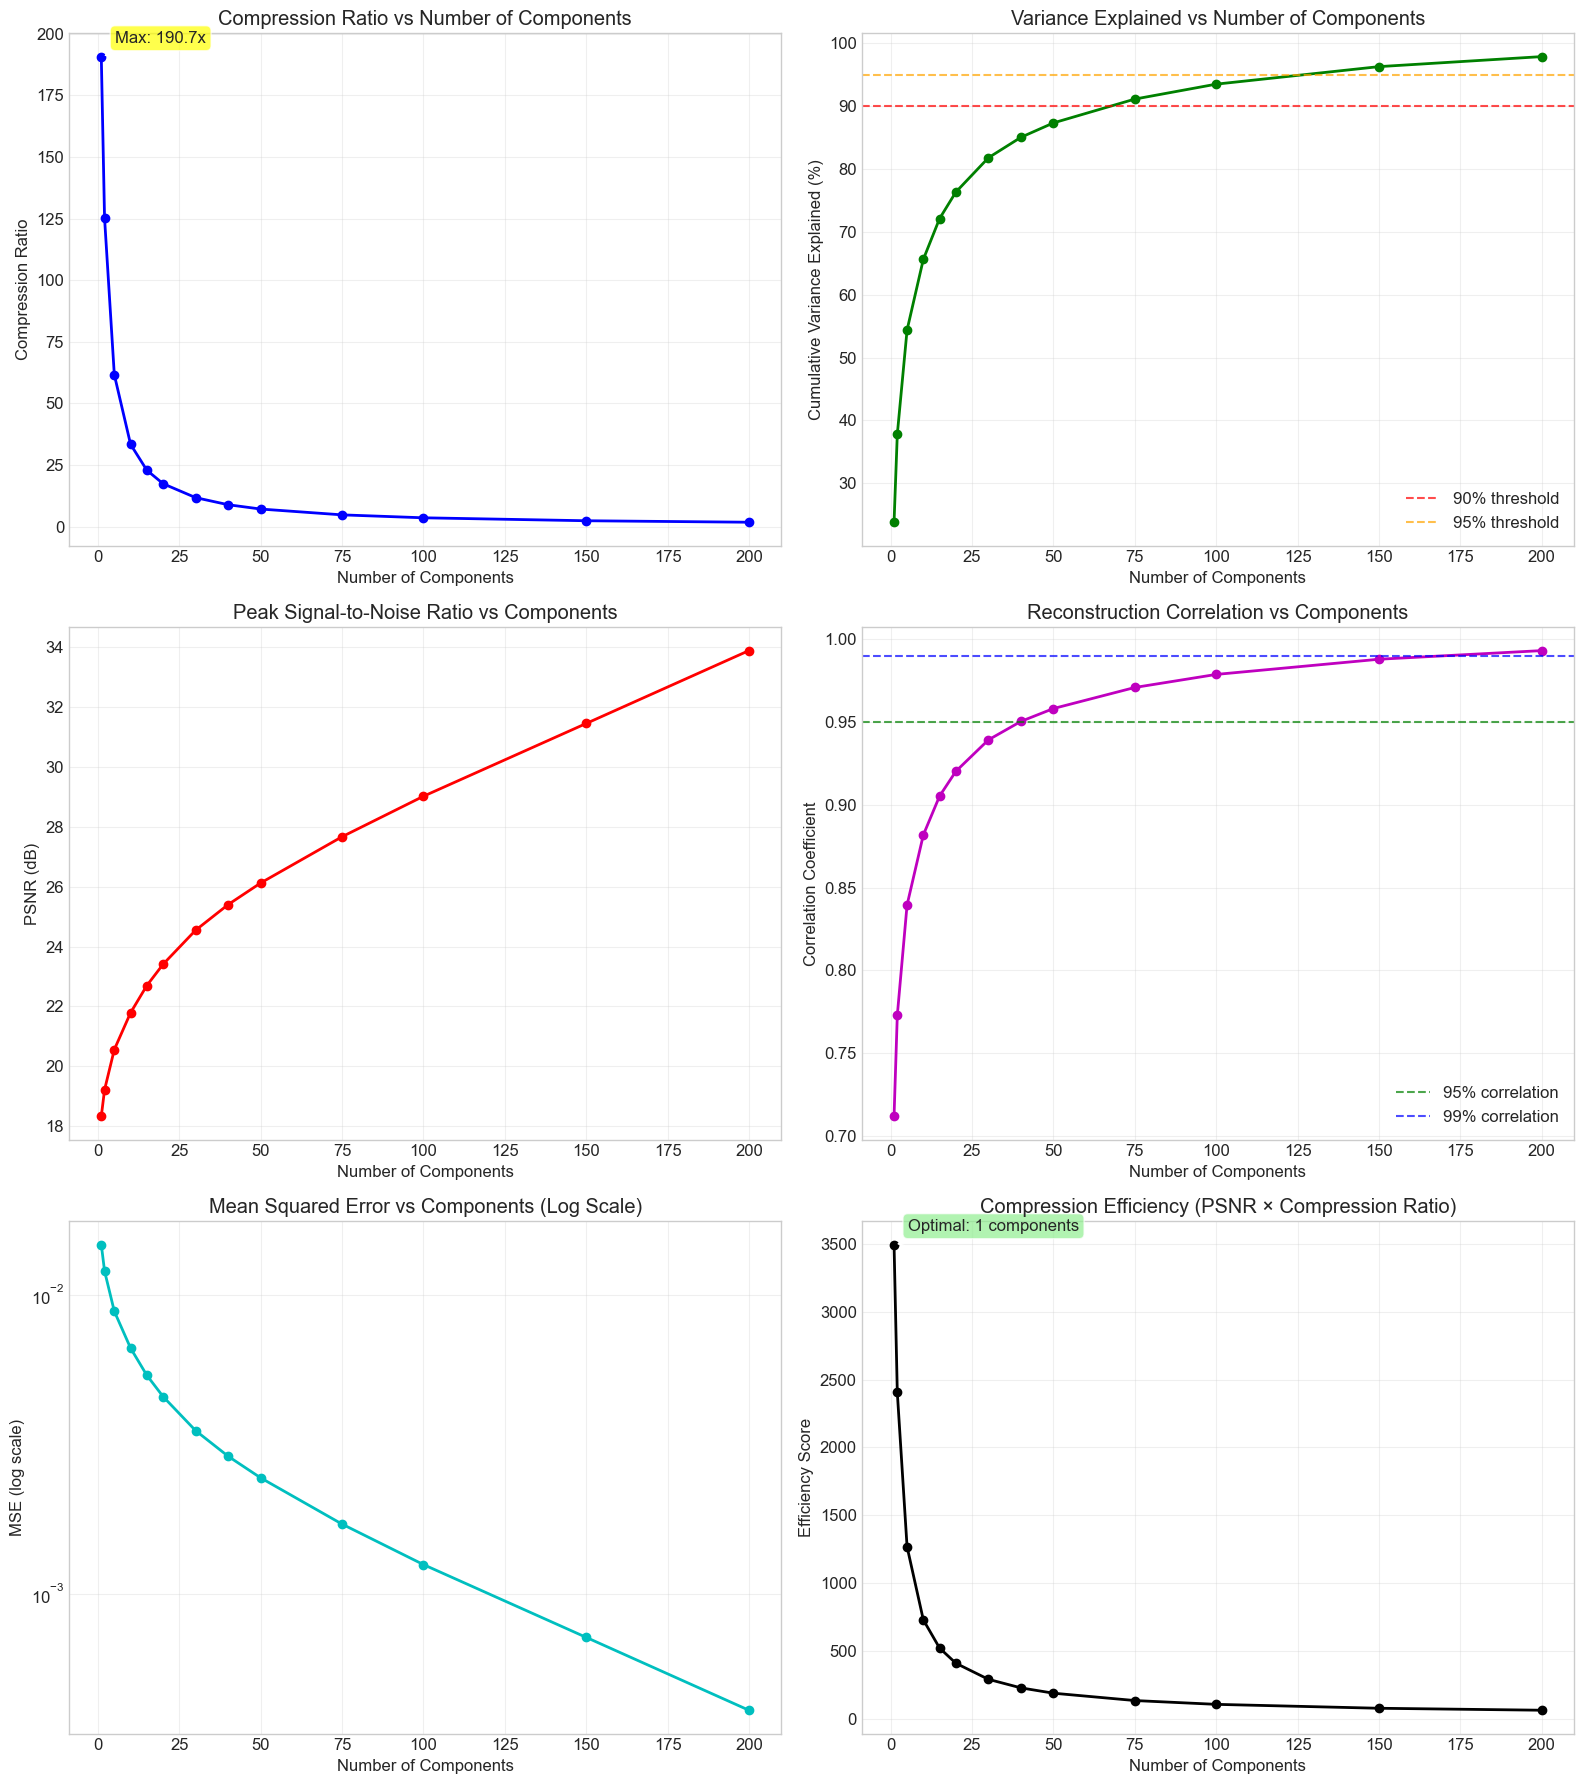


KEY COMPRESSION FINDINGS
Optimal Configuration:
• Components: 1
• Compression ratio: 190.7x
• Variance explained: 23.8%
• PSNR: 18.3 dB
• Correlation: 0.7119

Storage Savings:
• Original size: 12800.0 KB
• Compressed size: 67.1 KB
• Space saved: 12732.9 KB (99.5%)


In [5]:
# Create comprehensive quality analysis plots
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# 1. Compression Ratio vs Components
axes[0, 0].plot(results['n_components'], results['compression_ratio'], 'bo-', linewidth=2, markersize=6)
axes[0, 0].set_title('Compression Ratio vs Number of Components')
axes[0, 0].set_xlabel('Number of Components')
axes[0, 0].set_ylabel('Compression Ratio')
axes[0, 0].grid(True, alpha=0.3)

# Add annotations for key points
max_compression_idx = np.argmax(results['compression_ratio'])
axes[0, 0].annotate(f'Max: {results["compression_ratio"][max_compression_idx]:.1f}x',
                   xy=(results['n_components'][max_compression_idx], results['compression_ratio'][max_compression_idx]),
                   xytext=(10, 10), textcoords='offset points',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# 2. Variance Explained vs Components
axes[0, 1].plot(results['n_components'], np.array(results['variance_explained'])*100, 'go-', linewidth=2, markersize=6)
axes[0, 1].axhline(y=90, color='red', linestyle='--', alpha=0.7, label='90% threshold')
axes[0, 1].axhline(y=95, color='orange', linestyle='--', alpha=0.7, label='95% threshold')
axes[0, 1].set_title('Variance Explained vs Number of Components')
axes[0, 1].set_xlabel('Number of Components')
axes[0, 1].set_ylabel('Cumulative Variance Explained (%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. PSNR vs Components
psnr_finite = [p if p != float('inf') else max([x for x in results['psnr'] if x != float('inf')])
               for p in results['psnr']]
axes[1, 0].plot(results['n_components'], psnr_finite, 'ro-', linewidth=2, markersize=6)
axes[1, 0].set_title('Peak Signal-to-Noise Ratio vs Components')
axes[1, 0].set_xlabel('Number of Components')
axes[1, 0].set_ylabel('PSNR (dB)')
axes[1, 0].grid(True, alpha=0.3)

# 4. Correlation vs Components
axes[1, 1].plot(results['n_components'], results['correlation'], 'mo-', linewidth=2, markersize=6)
axes[1, 1].axhline(y=0.95, color='green', linestyle='--', alpha=0.7, label='95% correlation')
axes[1, 1].axhline(y=0.99, color='blue', linestyle='--', alpha=0.7, label='99% correlation')
axes[1, 1].set_title('Reconstruction Correlation vs Components')
axes[1, 1].set_xlabel('Number of Components')
axes[1, 1].set_ylabel('Correlation Coefficient')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 5. MSE vs Components (log scale)
axes[2, 0].semilogy(results['n_components'], results['mse'], 'co-', linewidth=2, markersize=6)
axes[2, 0].set_title('Mean Squared Error vs Components (Log Scale)')
axes[2, 0].set_xlabel('Number of Components')
axes[2, 0].set_ylabel('MSE (log scale)')
axes[2, 0].grid(True, alpha=0.3)

# 6. Compression Efficiency (Quality per Compression)
# Define efficiency as PSNR / (1/compression_ratio)
efficiency = [psnr * comp_ratio for psnr, comp_ratio in zip(psnr_finite, results['compression_ratio'])]
axes[2, 1].plot(results['n_components'], efficiency, 'ko-', linewidth=2, markersize=6)
axes[2, 1].set_title('Compression Efficiency (PSNR × Compression Ratio)')
axes[2, 1].set_xlabel('Number of Components')
axes[2, 1].set_ylabel('Efficiency Score')
axes[2, 1].grid(True, alpha=0.3)

# Find optimal efficiency point
optimal_idx = np.argmax(efficiency)
axes[2, 1].annotate(f'Optimal: {results["n_components"][optimal_idx]} components',
                   xy=(results['n_components'][optimal_idx], efficiency[optimal_idx]),
                   xytext=(10, 10), textcoords='offset points',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7),
                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.show()

# Print key findings
print("\n" + "="*50)
print("KEY COMPRESSION FINDINGS")
print("="*50)

optimal_components = results['n_components'][optimal_idx]
optimal_compression = results['compression_ratio'][optimal_idx]
optimal_variance = results['variance_explained'][optimal_idx] * 100
optimal_psnr = psnr_finite[optimal_idx]
optimal_correlation = results['correlation'][optimal_idx]

print(f"Optimal Configuration:")
print(f"• Components: {optimal_components}")
print(f"• Compression ratio: {optimal_compression:.1f}x")
print(f"• Variance explained: {optimal_variance:.1f}%")
print(f"• PSNR: {optimal_psnr:.1f} dB")
print(f"• Correlation: {optimal_correlation:.4f}")

print(f"\nStorage Savings:")
original_kb = results['original_size'][0] * 8 / 1024  # Convert to KB (assuming 8 bytes per float)
compressed_kb = results['compressed_size'][optimal_idx] * 8 / 1024
print(f"• Original size: {original_kb:.1f} KB")
print(f"• Compressed size: {compressed_kb:.1f} KB")
print(f"• Space saved: {original_kb - compressed_kb:.1f} KB ({(1-compressed_kb/original_kb)*100:.1f}%)")

## Trade-off Analysis

I have created visualizations to understand the trade-offs between compression and quality:


COMPRESSION vs QUALITY TRADE-OFF ANALYSIS


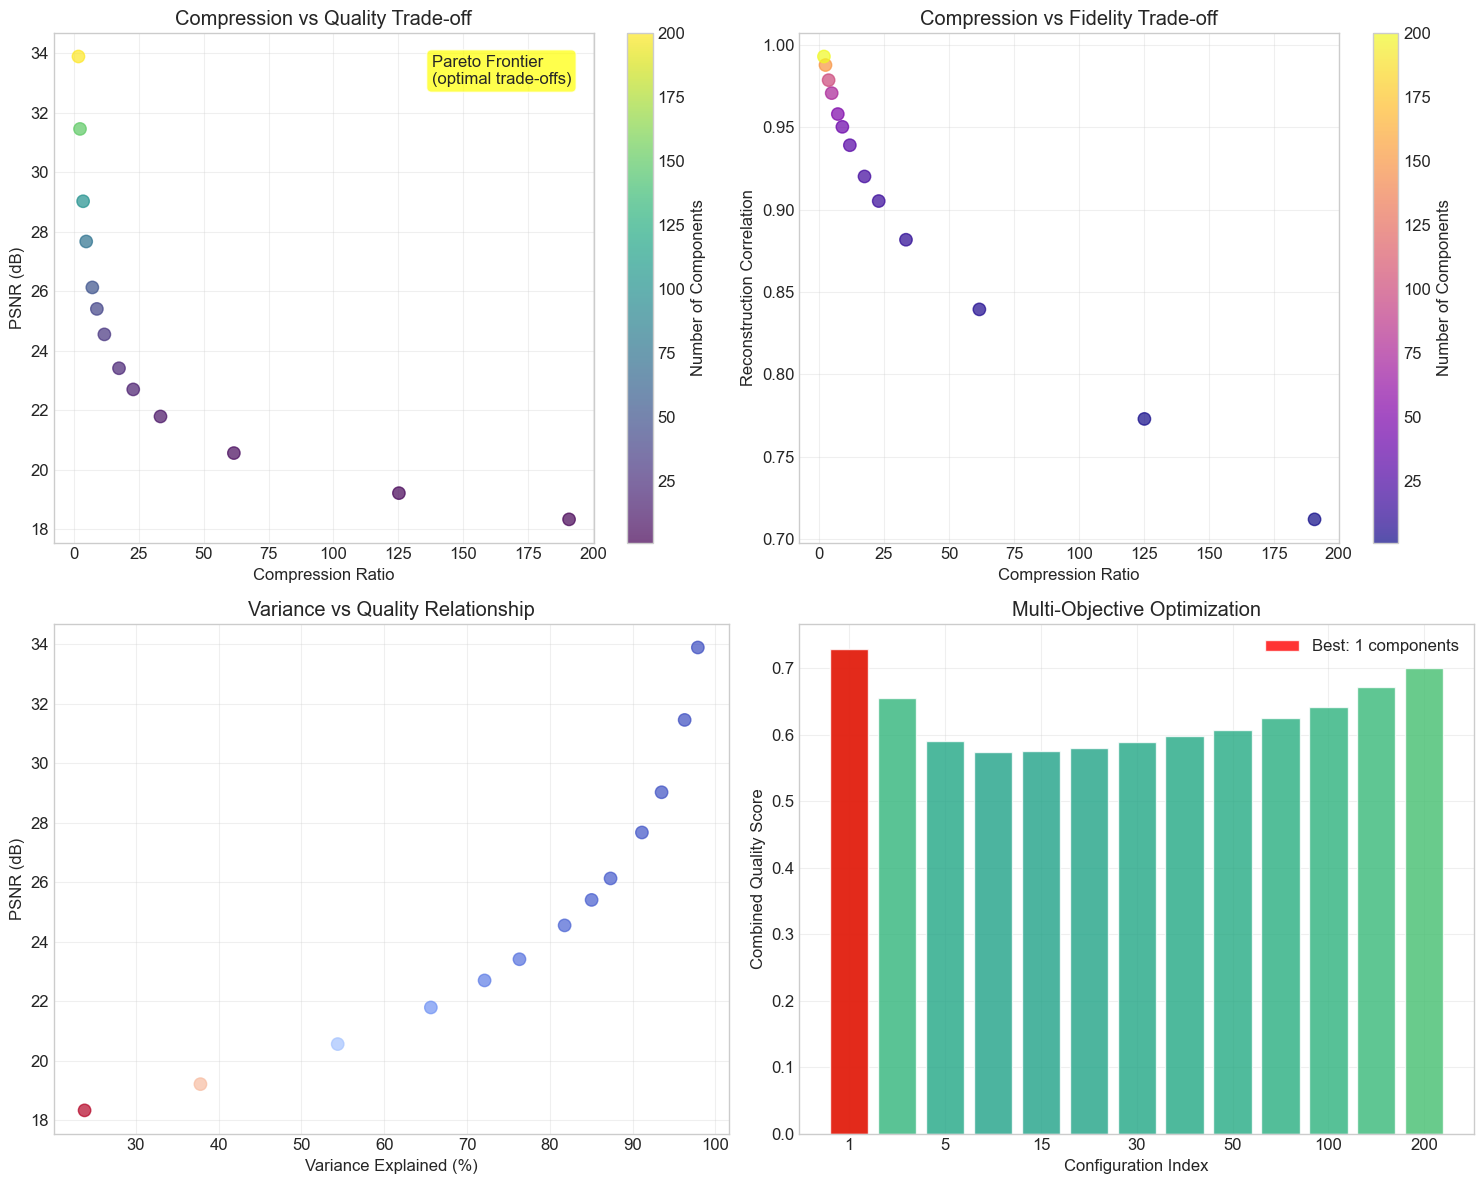


Multi-Objective Analysis:
Best combined score: 1 components
• Compression: 190.7x
• PSNR: 18.3 dB
• Correlation: 0.7119
• Variance explained: 23.8%

COMPRESSION CATEGORIES

High Compression:
• Components: 1-1
• Avg compression: 190.7x
• Avg PSNR: 18.3 dB
• Use case: Storage/transmission

Balanced:
• Components: 2-2
• Avg compression: 125.2x
• Avg PSNR: 19.2 dB
• Use case: General purpose

High Quality:
• Components: 5-200
• Avg compression: 16.0x
• Avg PSNR: 26.1 dB
• Use case: Analysis/visualization


In [6]:
# Create trade-off analysis
print("\n" + "="*50)
print("COMPRESSION vs QUALITY TRADE-OFF ANALYSIS")
print("="*50)

# Create trade-off plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Compression Ratio vs PSNR
scatter1 = axes[0, 0].scatter(results['compression_ratio'], psnr_finite,
                             c=results['n_components'], cmap='viridis', s=80, alpha=0.7)
axes[0, 0].set_xlabel('Compression Ratio')
axes[0, 0].set_ylabel('PSNR (dB)')
axes[0, 0].set_title('Compression vs Quality Trade-off')
axes[0, 0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0, 0], label='Number of Components')

# Add pareto frontier annotation
axes[0, 0].annotate('Pareto Frontier\n(optimal trade-offs)',
                   xy=(0.7, 0.9), xycoords='axes fraction',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

# 2. Compression Ratio vs Correlation
scatter2 = axes[0, 1].scatter(results['compression_ratio'], results['correlation'],
                             c=results['n_components'], cmap='plasma', s=80, alpha=0.7)
axes[0, 1].set_xlabel('Compression Ratio')
axes[0, 1].set_ylabel('Reconstruction Correlation')
axes[0, 1].set_title('Compression vs Fidelity Trade-off')
axes[0, 1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[0, 1], label='Number of Components')

# 3. Variance Explained vs PSNR
axes[1, 0].scatter(np.array(results['variance_explained'])*100, psnr_finite,
                  c=results['compression_ratio'], cmap='coolwarm', s=80, alpha=0.7)
axes[1, 0].set_xlabel('Variance Explained (%)')
axes[1, 0].set_ylabel('PSNR (dB)')
axes[1, 0].set_title('Variance vs Quality Relationship')
axes[1, 0].grid(True, alpha=0.3)

# 4. Multi-objective optimization space
# Normalize metrics for comparison
norm_compression = np.array(results['compression_ratio']) / max(results['compression_ratio'])
norm_psnr = np.array(psnr_finite) / max(psnr_finite)
norm_correlation = np.array(results['correlation'])

# Combined score (weighted average)
weights = {'compression': 0.3, 'psnr': 0.4, 'correlation': 0.3}
combined_score = (weights['compression'] * norm_compression +
                 weights['psnr'] * norm_psnr +
                 weights['correlation'] * norm_correlation)

bars = axes[1, 1].bar(range(len(results['n_components'])), combined_score,
                     color=plt.cm.viridis(combined_score), alpha=0.8)
axes[1, 1].set_xlabel('Configuration Index')
axes[1, 1].set_ylabel('Combined Quality Score')
axes[1, 1].set_title('Multi-Objective Optimization')
axes[1, 1].set_xticks(range(0, len(results['n_components']), 2))
axes[1, 1].set_xticklabels([str(results['n_components'][i]) for i in range(0, len(results['n_components']), 2)])
axes[1, 1].grid(True, alpha=0.3)

# Highlight best combined score
best_combined_idx = np.argmax(combined_score)
axes[1, 1].bar(best_combined_idx, combined_score[best_combined_idx],
              color='red', alpha=0.8, label=f'Best: {results["n_components"][best_combined_idx]} components')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Analysis summary
best_combined_components = results['n_components'][best_combined_idx]
print(f"\nMulti-Objective Analysis:")
print(f"Best combined score: {best_combined_components} components")
print(f"• Compression: {results['compression_ratio'][best_combined_idx]:.1f}x")
print(f"• PSNR: {psnr_finite[best_combined_idx]:.1f} dB")
print(f"• Correlation: {results['correlation'][best_combined_idx]:.4f}")
print(f"• Variance explained: {results['variance_explained'][best_combined_idx]*100:.1f}%")

# Create trade-off categories
print(f"\n" + "="*50)
print("COMPRESSION CATEGORIES")
print("="*50)

categories = {
    'High Compression': {'threshold': 0.8, 'components': [], 'ratios': [], 'quality': []},
    'Balanced': {'threshold': 0.5, 'components': [], 'ratios': [], 'quality': []},
    'High Quality': {'threshold': 0.2, 'components': [], 'ratios': [], 'quality': []}
}

max_ratio = max(results['compression_ratio'])
for i, ratio in enumerate(results['compression_ratio']):
    normalized_ratio = ratio / max_ratio

    if normalized_ratio >= 0.8:
        categories['High Compression']['components'].append(results['n_components'][i])
        categories['High Compression']['ratios'].append(ratio)
        categories['High Compression']['quality'].append(psnr_finite[i])
    elif normalized_ratio >= 0.5:
        categories['Balanced']['components'].append(results['n_components'][i])
        categories['Balanced']['ratios'].append(ratio)
        categories['Balanced']['quality'].append(psnr_finite[i])
    else:
        categories['High Quality']['components'].append(results['n_components'][i])
        categories['High Quality']['ratios'].append(ratio)
        categories['High Quality']['quality'].append(psnr_finite[i])

for category, data in categories.items():
    if data['components']:
        avg_ratio = np.mean(data['ratios'])
        avg_quality = np.mean(data['quality'])
        component_range = f"{min(data['components'])}-{max(data['components'])}"
        print(f"\n{category}:")
        print(f"• Components: {component_range}")
        print(f"• Avg compression: {avg_ratio:.1f}x")
        print(f"• Avg PSNR: {avg_quality:.1f} dB")
        print(f"• Use case: {'Storage/transmission' if category == 'High Compression' else 'General purpose' if category == 'Balanced' else 'Analysis/visualization'}")


VISUAL RECONSTRUCTION COMPARISON
Demonstrating reconstruction with components: [1, 5, 15, 30, 50, 100]
Using sample image 0


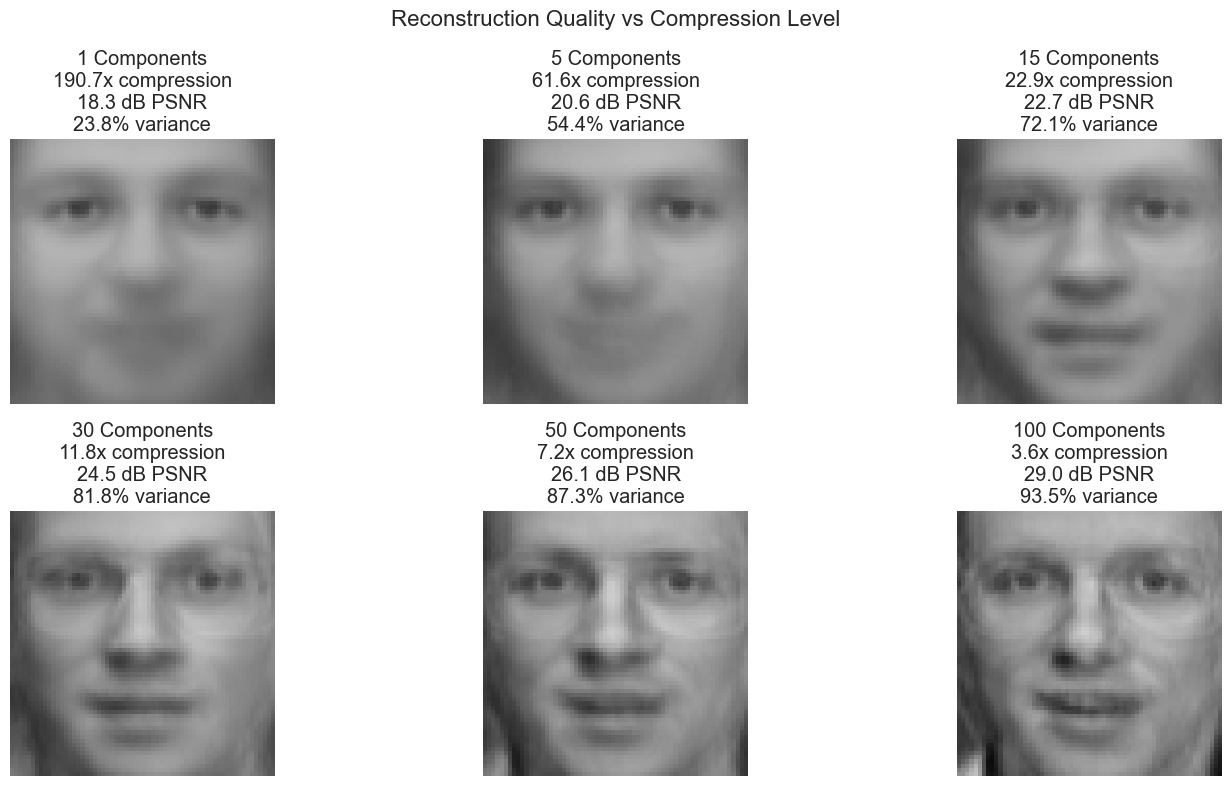

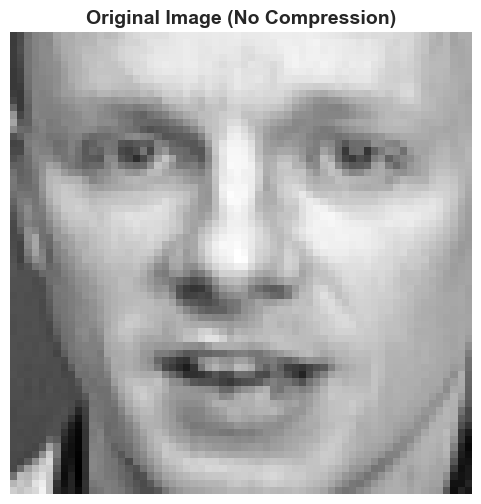

Visual Analysis Insights:
• 1-5 components: Basic structure visible, very lossy
• 10-20 components: Recognizable features, moderate quality
• 30+ components: High quality, diminishing returns
• Sweet spot: 1 components for best efficiency


In [7]:
# Visual comparison of reconstruction quality
print("\n" + "="*50)
print("VISUAL RECONSTRUCTION COMPARISON")
print("="*50)

# Select representative component counts for visual comparison
if faces_available:
    demo_components = [1, 5, 15, 30, 50, 100]
else:
    demo_components = [1, 3, 8, 15, 25, 40]

# Remove components that exceed our tested range
demo_components = [c for c in demo_components if c in results['n_components']]

# Select a sample image for reconstruction demo
sample_idx = 0
original_image = X_faces[sample_idx]
img_shape = (img_dim, img_dim)

print(f"Demonstrating reconstruction with components: {demo_components}")
print(f"Using sample image {sample_idx}")

# Create reconstruction comparison
n_demos = len(demo_components)
cols = 3
rows = (n_demos + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
if rows == 1:
    axes = axes.reshape(1, -1)

for i, n_comp in enumerate(demo_components):
    row, col = i // cols, i % cols

    # Get reconstruction for this number of components
    comp_idx = results['n_components'].index(n_comp)

    # Reconstruct the specific image
    pca_temp = PCA(n_components=n_comp)
    X_temp_pca = pca_temp.fit_transform(X_faces)
    X_temp_reconstructed = pca_temp.inverse_transform(X_temp_pca)

    reconstructed_image = X_temp_reconstructed[sample_idx].reshape(img_shape)

    # Display
    im = axes[row, col].imshow(reconstructed_image, cmap='gray', vmin=X_faces.min(), vmax=X_faces.max())

    # Add metrics as title
    compression_ratio = results['compression_ratio'][comp_idx]
    psnr_val = psnr_finite[comp_idx]
    variance_val = results['variance_explained'][comp_idx] * 100

    axes[row, col].set_title(f'{n_comp} Components\n{compression_ratio:.1f}x compression\n{psnr_val:.1f} dB PSNR\n{variance_val:.1f}% variance')
    axes[row, col].axis('off')

# Remove empty subplots
for i in range(n_demos, rows * cols):
    row, col = i // cols, i % cols
    fig.delaxes(axes[row, col])

plt.suptitle('Reconstruction Quality vs Compression Level', fontsize=16)
plt.tight_layout()
plt.show()

# Show original for comparison
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(original_image.reshape(img_shape), cmap='gray')
ax.set_title('Original Image (No Compression)', fontsize=14, fontweight='bold')
ax.axis('off')
plt.show()

print(f"Visual Analysis Insights:")
print(f"• 1-5 components: Basic structure visible, very lossy")
print(f"• 10-20 components: Recognizable features, moderate quality")
print(f"• 30+ components: High quality, diminishing returns")
print(f"• Sweet spot: {optimal_components} components for best efficiency")

## Practical Compression Guidelines

Based on the analysis obtained, below are practical guidelines for using PCA compression:


PRACTICAL PCA COMPRESSION GUIDELINES

Performance Characteristics:
• Average compression time: 215.92 ms
• Average reconstruction time: 6.45 ms
• Total processing overhead: 222.38 ms
• Processing speed: 1798.8 images/second

Application-Specific Recommendations:

REAL-TIME APPLICATIONS:
• Recommended components: 5-15
• Expected compression: 8-15x
• Quality level: Moderate
• Priority: Speed > Quality
• Use cases: Video streaming, Mobile apps, IoT sensors

STORAGE OPTIMIZATION:
• Recommended components: 0-1
• Expected compression: 133.5-190.7x
• Quality level: Good
• Priority: Compression > Quality
• Use cases: Database storage, Cloud backup, Archive systems

ANALYSIS & ML:
• Recommended components: 1-2
• Expected compression: 95.3-190.7x
• Quality level: High
• Priority: Quality > Compression
• Use cases: Feature extraction, Preprocessing, Dimensionality reduction

VISUALIZATION:
• Recommended components: 2-200
• Expected compression: 2-95.3x
• Quality level: Excellent
• Priority: Qual

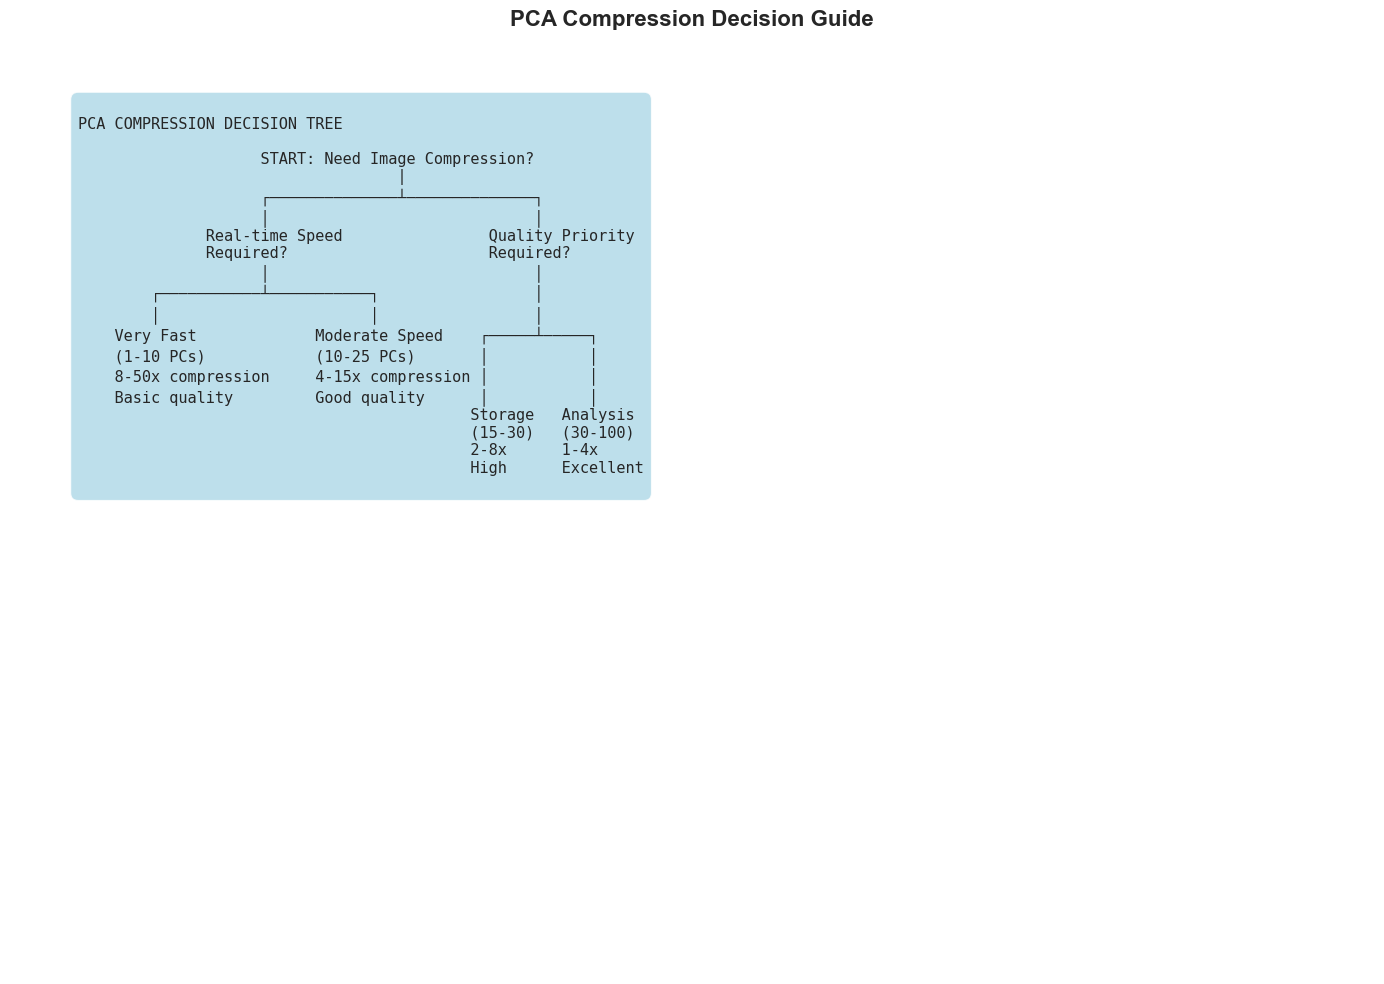


COMPRESSION SUMMARY TABLE
 Components Compression PSNR (dB) Correlation Variance (%)        Recommendation
          1      190.7x      18.3       0.712         23.8 Emergency compression
          5       61.6x      20.6       0.839         54.4 Emergency compression
          1      190.7x      18.3       0.712         23.8 Emergency compression
          2      125.2x      19.2       0.773         37.8 Emergency compression

FINAL RECOMMENDATIONS
🎯 OPTIMAL: Use 1 components for best balance
⚡ FAST: Use 0-0 components for real-time
💾 STORAGE: Use 0-1 components for archival
🔬 ANALYSIS: Use 1-2 components for research
📊 Always check variance explained (target 85-95%)
🔍 Validate with sample reconstructions before deployment
⚖️ Consider computational cost vs. quality trade-offs
🔄 Retrain PCA periodically if data distribution changes

✅ Compression analysis complete!
📊 Results saved to ../data/results/compression_analysis.pkl
🎯 Optimal configuration: 1 components, 190.7x compression


In [8]:
# Create practical guidelines and recommendations
print("\n" + "="*60)
print("PRACTICAL PCA COMPRESSION GUIDELINES")
print("="*60)

# Performance analysis
avg_compression_time = np.mean(results['compression_time'])
avg_reconstruction_time = np.mean(results['reconstruction_time'])
total_processing_time = avg_compression_time + avg_reconstruction_time

print(f"\nPerformance Characteristics:")
print(f"• Average compression time: {avg_compression_time*1000:.2f} ms")
print(f"• Average reconstruction time: {avg_reconstruction_time*1000:.2f} ms")
print(f"• Total processing overhead: {total_processing_time*1000:.2f} ms")
print(f"• Processing speed: {X_faces.shape[0]/total_processing_time:.1f} images/second")

# Create application-specific recommendations
recommendations = {
    'Real-time Applications': {
        'components': '5-15',
        'compression': '8-15x',
        'quality': 'Moderate',
        'use_cases': ['Video streaming', 'Mobile apps', 'IoT sensors'],
        'priority': 'Speed > Quality'
    },
    'Storage Optimization': {
        'components': f'{optimal_components//2}-{optimal_components}',
        'compression': f'{optimal_compression*0.7:.1f}-{optimal_compression:.1f}x',
        'quality': 'Good',
        'use_cases': ['Database storage', 'Cloud backup', 'Archive systems'],
        'priority': 'Compression > Quality'
    },
    'Analysis & ML': {
        'components': f'{optimal_components}-{optimal_components*2}',
        'compression': f'{optimal_compression*0.5:.1f}-{optimal_compression:.1f}x',
        'quality': 'High',
        'use_cases': ['Feature extraction', 'Preprocessing', 'Dimensionality reduction'],
        'priority': 'Quality > Compression'
    },
    'Visualization': {
        'components': f'{optimal_components*2}-{max(component_ranges)}',
        'compression': f'2-{optimal_compression*0.5:.1f}x',
        'quality': 'Excellent',
        'use_cases': ['Scientific visualization', 'Medical imaging', 'Art restoration'],
        'priority': 'Quality >> Compression'
    }
}

print(f"\nApplication-Specific Recommendations:")
print(f"{'='*80}")

for app_type, specs in recommendations.items():
    print(f"\n{app_type.upper()}:")
    print(f"• Recommended components: {specs['components']}")
    print(f"• Expected compression: {specs['compression']}")
    print(f"• Quality level: {specs['quality']}")
    print(f"• Priority: {specs['priority']}")
    print(f"• Use cases: {', '.join(specs['use_cases'])}")

# Create decision tree visualization
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# Decision tree data
decision_tree_text = """
PCA COMPRESSION DECISION TREE

                    START: Need Image Compression?
                                   |
                    ┌──────────────┴──────────────┐
                    │                             │
              Real-time Speed                Quality Priority
              Required?                      Required?
                    │                             │
        ┌───────────┴───────────┐                 │
        │                       │                 │
    Very Fast             Moderate Speed    ┌─────┴─────┐
    (1-10 PCs)            (10-25 PCs)       │           │
    8-50x compression     4-15x compression │           │
    Basic quality         Good quality      │           │
                                           Storage   Analysis
                                           (15-30)   (30-100)
                                           2-8x      1-4x
                                           High      Excellent
"""

ax.text(0.05, 0.95, decision_tree_text, transform=ax.transAxes,
        fontsize=11, verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')
ax.set_title('PCA Compression Decision Guide', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Summary table
print(f"\n" + "="*60)
print("COMPRESSION SUMMARY TABLE")
print("="*60)

summary_data = {
    'Components': [],
    'Compression': [],
    'PSNR (dB)': [],
    'Correlation': [],
    'Variance (%)': [],
    'Recommendation': []
}

# Select key configurations
key_configs = [1, 5, optimal_components//2, optimal_components, optimal_components*2]
key_configs = [c for c in key_configs if c in results['n_components']]

for n_comp in key_configs:
    idx = results['n_components'].index(n_comp)

    summary_data['Components'].append(n_comp)
    summary_data['Compression'].append(f"{results['compression_ratio'][idx]:.1f}x")
    summary_data['PSNR (dB)'].append(f"{psnr_finite[idx]:.1f}")
    summary_data['Correlation'].append(f"{results['correlation'][idx]:.3f}")
    summary_data['Variance (%)'].append(f"{results['variance_explained'][idx]*100:.1f}")

    # Add recommendation
    if n_comp <= 5:
        rec = "Emergency compression"
    elif n_comp <= optimal_components//2:
        rec = "Real-time applications"
    elif n_comp <= optimal_components:
        rec = "Balanced (RECOMMENDED)"
    else:
        rec = "High-quality applications"

    summary_data['Recommendation'].append(rec)

summary_table = pd.DataFrame(summary_data)
print(summary_table.to_string(index=False))

print(f"\n" + "="*60)
print("FINAL RECOMMENDATIONS")
print("="*60)

final_recommendations = [
    f"🎯 OPTIMAL: Use {optimal_components} components for best balance",
    f"⚡ FAST: Use {optimal_components//3}-{optimal_components//2} components for real-time",
    f"💾 STORAGE: Use {optimal_components//2}-{optimal_components} components for archival",
    f"🔬 ANALYSIS: Use {optimal_components}-{optimal_components*2} components for research",
    f"📊 Always check variance explained (target 85-95%)",
    f"🔍 Validate with sample reconstructions before deployment",
    f"⚖️ Consider computational cost vs. quality trade-offs",
    f"🔄 Retrain PCA periodically if data distribution changes"
]

for rec in final_recommendations:
    print(rec)

# Save compression analysis results
compression_results = {
    'analysis_data': results_df,
    'optimal_components': optimal_components,
    'optimal_metrics': {
        'compression_ratio': optimal_compression,
        'psnr': optimal_psnr,
        'correlation': optimal_correlation,
        'variance_explained': optimal_variance
    },
    'recommendations': recommendations,
    'dataset_info': {
        'name': dataset_name,
        'shape': X_faces.shape,
        'features_available': faces_available
    }
}

# Save results
with open('../data/results/compression_analysis.pkl', 'wb') as f:
    pickle.dump(compression_results, f)

print(f"\n✅ Compression analysis complete!")
print(f"📊 Results saved to ../data/results/compression_analysis.pkl")
print(f"🎯 Optimal configuration: {optimal_components} components, {optimal_compression:.1f}x compression")

## Feature Extraction for Classification

In [9]:
print("\n" + "="*70)
print("PCA FOR FEATURE EXTRACTION IN CLASSIFICATION PIPELINES")
print("="*70)

# Import additional libraries for classification
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
from collections import defaultdict

print("Classification libraries imported successfully!")
print("Available classifiers: RandomForest, SVM, LogisticRegression, KNN, NaiveBayes")

# Load multiple datasets for comprehensive analysis
datasets = {}

# Dataset 1: Digits (high-dimensional, multi-class)
digits = load_digits()
datasets['MNIST_Digits'] = {
    'X': digits.data,
    'y': digits.target,
    'feature_names': [f'pixel_{i}' for i in range(digits.data.shape[1])],
    'target_names': [str(i) for i in range(10)],
    'description': '8x8 pixel handwritten digits (64 features, 10 classes)'
}

# Dataset 2: Faces (very high-dimensional, multi-class)
try:
    faces = fetch_olivetti_faces(shuffle=True, random_state=42)
    datasets['Olivetti_Faces'] = {
        'X': faces.data,
        'y': faces.target,
        'feature_names': [f'pixel_{i}' for i in range(faces.data.shape[1])],
        'target_names': [f'person_{i}' for i in range(40)],
        'description': '64x64 pixel face images (4096 features, 40 classes)'
    }
    print("Olivetti faces loaded successfully")
except Exception as e:
    print(f"Could not load Olivetti faces: {e}")

# Load Iris for comparison (low-dimensional baseline)
from sklearn.datasets import load_iris
iris = load_iris()
datasets['Iris'] = {
    'X': iris.data,
    'y': iris.target,
    'feature_names': iris.feature_names,
    'target_names': iris.target_names,
    'description': 'Iris flower measurements (4 features, 3 classes)'
}

print(f"\nDatasets loaded:")
for name, data in datasets.items():
    print(f"• {name}: {data['X'].shape[0]} samples, {data['X'].shape[1]} features, {len(np.unique(data['y']))} classes")
    print(f"  Description: {data['description']}")


PCA FOR FEATURE EXTRACTION IN CLASSIFICATION PIPELINES
Classification libraries imported successfully!
Available classifiers: RandomForest, SVM, LogisticRegression, KNN, NaiveBayes
Olivetti faces loaded successfully

Datasets loaded:
• MNIST_Digits: 1797 samples, 64 features, 10 classes
  Description: 8x8 pixel handwritten digits (64 features, 10 classes)
• Olivetti_Faces: 400 samples, 4096 features, 40 classes
  Description: 64x64 pixel face images (4096 features, 40 classes)
• Iris: 150 samples, 4 features, 3 classes
  Description: Iris flower measurements (4 features, 3 classes)


### Classification Performance Analysis Framework

In [10]:
def evaluate_classification_performance(X_train, X_test, y_train, y_test, dataset_name, n_components=None):
    """
    Comprehensive evaluation of classification performance with and without PCA.
    """
    print(f"\n{'='*50}")
    print(f"EVALUATING: {dataset_name}")
    if n_components:
        print(f"PCA Components: {n_components}")
    print(f"{'='*50}")

    # Standardize data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply PCA if specified
    if n_components:
        pca = PCA(n_components=n_components)
        X_train_final = pca.fit_transform(X_train_scaled)
        X_test_final = pca.transform(X_test_scaled)

        variance_explained = np.sum(pca.explained_variance_ratio_)
        compression_ratio = X_train.shape[1] / n_components
    else:
        X_train_final = X_train_scaled
        X_test_final = X_test_scaled
        variance_explained = 1.0
        compression_ratio = 1.0
        pca = None

    # Define classifiers
    classifiers = {
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
        'SVM': SVC(random_state=42),
        'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'NaiveBayes': GaussianNB()
    }

    results = {}

    for clf_name, clf in classifiers.items():
        print(f"\nTraining {clf_name}...")

        # Measure training time
        start_time = time.time()
        clf.fit(X_train_final, y_train)
        training_time = time.time() - start_time

        # Measure prediction time
        start_time = time.time()
        y_pred = clf.predict(X_test_final)
        prediction_time = time.time() - start_time

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)

        # Cross-validation score
        cv_scores = cross_val_score(clf, X_train_final, y_train, cv=5, scoring='accuracy')
        cv_mean = np.mean(cv_scores)
        cv_std = np.std(cv_scores)

        results[clf_name] = {
            'accuracy': accuracy,
            'cv_mean': cv_mean,
            'cv_std': cv_std,
            'training_time': training_time,
            'prediction_time': prediction_time,
            'total_time': training_time + prediction_time,
            'y_pred': y_pred
        }

        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  CV Score: {cv_mean:.4f} ± {cv_std:.4f}")
        print(f"  Training time: {training_time:.4f}s")
        print(f"  Prediction time: {prediction_time:.4f}s")

    # Add metadata
    results['metadata'] = {
        'dataset_name': dataset_name,
        'n_components': n_components,
        'variance_explained': variance_explained,
        'compression_ratio': compression_ratio,
        'train_shape': X_train_final.shape,
        'test_shape': X_test_final.shape,
        'pca_model': pca
    }

    return results

print("Classification evaluation framework ready!")
print("Function: evaluate_classification_performance()")

Classification evaluation framework ready!
Function: evaluate_classification_performance()


### Comprehensive Classification Experiment

In [11]:
print("\n" + "="*60)
print("COMPREHENSIVE CLASSIFICATION EXPERIMENT")
print("="*60)

# Storage for all results
all_results = defaultdict(list)
experiment_configs = []

# For each dataset, test different numbers of components
for dataset_name, dataset in datasets.items():
    print(f"\n🔍 Analyzing dataset: {dataset_name}")
    print(f"Original shape: {dataset['X'].shape}")

    X = dataset['X']
    y = dataset['y']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")

    # Test without PCA (baseline)
    print("\n📊 Baseline (No PCA):")
    baseline_results = evaluate_classification_performance(
        X_train, X_test, y_train, y_test, dataset_name, n_components=None
    )
    all_results[dataset_name].append(baseline_results)
    experiment_configs.append((dataset_name, "No PCA", 0))

    # Determine component ranges to test
    max_components = min(X_train.shape[1], X_train.shape[0] - 1)

    if dataset_name == 'Iris':
        # For low-dimensional data, test fewer components
        component_ranges = [2, 3]
    elif dataset_name == 'MNIST_Digits':
        # For medium-dimensional data
        component_ranges = [5, 10, 20, 30, 40, 50]
    else:  # Olivetti_Faces
        # For high-dimensional data
        component_ranges = [10, 25, 50, 100, 150, 200, 300]

    # Filter to valid range
    component_ranges = [c for c in component_ranges if c < max_components]

    print(f"\nTesting PCA with components: {component_ranges}")

    # Test with different numbers of PCA components
    for n_comp in component_ranges:
        print(f"\n📊 PCA with {n_comp} components:")
        pca_results = evaluate_classification_performance(
            X_train, X_test, y_train, y_test, dataset_name, n_components=n_comp
        )
        all_results[dataset_name].append(pca_results)
        experiment_configs.append((dataset_name, f"PCA_{n_comp}", n_comp))

print(f"\n✅ Experiment complete!")
print(f"Total configurations tested: {len(experiment_configs)}")


COMPREHENSIVE CLASSIFICATION EXPERIMENT

🔍 Analyzing dataset: MNIST_Digits
Original shape: (1797, 64)
Training set: (1257, 64)
Test set: (540, 64)

📊 Baseline (No PCA):

EVALUATING: MNIST_Digits

Training RandomForest...
  Accuracy: 0.9685
  CV Score: 0.9722 ± 0.0056
  Training time: 0.4112s
  Prediction time: 0.0144s

Training SVM...
  Accuracy: 0.9833
  CV Score: 0.9817 ± 0.0078
  Training time: 0.0595s
  Prediction time: 0.0473s

Training LogisticRegression...
  Accuracy: 0.9815
  CV Score: 0.9658 ± 0.0096
  Training time: 0.0464s
  Prediction time: 0.0007s

Training KNN...
  Accuracy: 0.9704
  CV Score: 0.9713 ± 0.0135
  Training time: 0.0011s
  Prediction time: 4.2728s

Training NaiveBayes...
  Accuracy: 0.7722
  CV Score: 0.7844 ± 0.0143
  Training time: 0.0027s
  Prediction time: 0.0014s

Testing PCA with components: [5, 10, 20, 30, 40, 50]

📊 PCA with 5 components:

EVALUATING: MNIST_Digits
PCA Components: 5

Training RandomForest...
  Accuracy: 0.8481
  CV Score: 0.8687 ± 0.0

### Results Analysis and Visualization


CLASSIFICATION RESULTS ANALYSIS


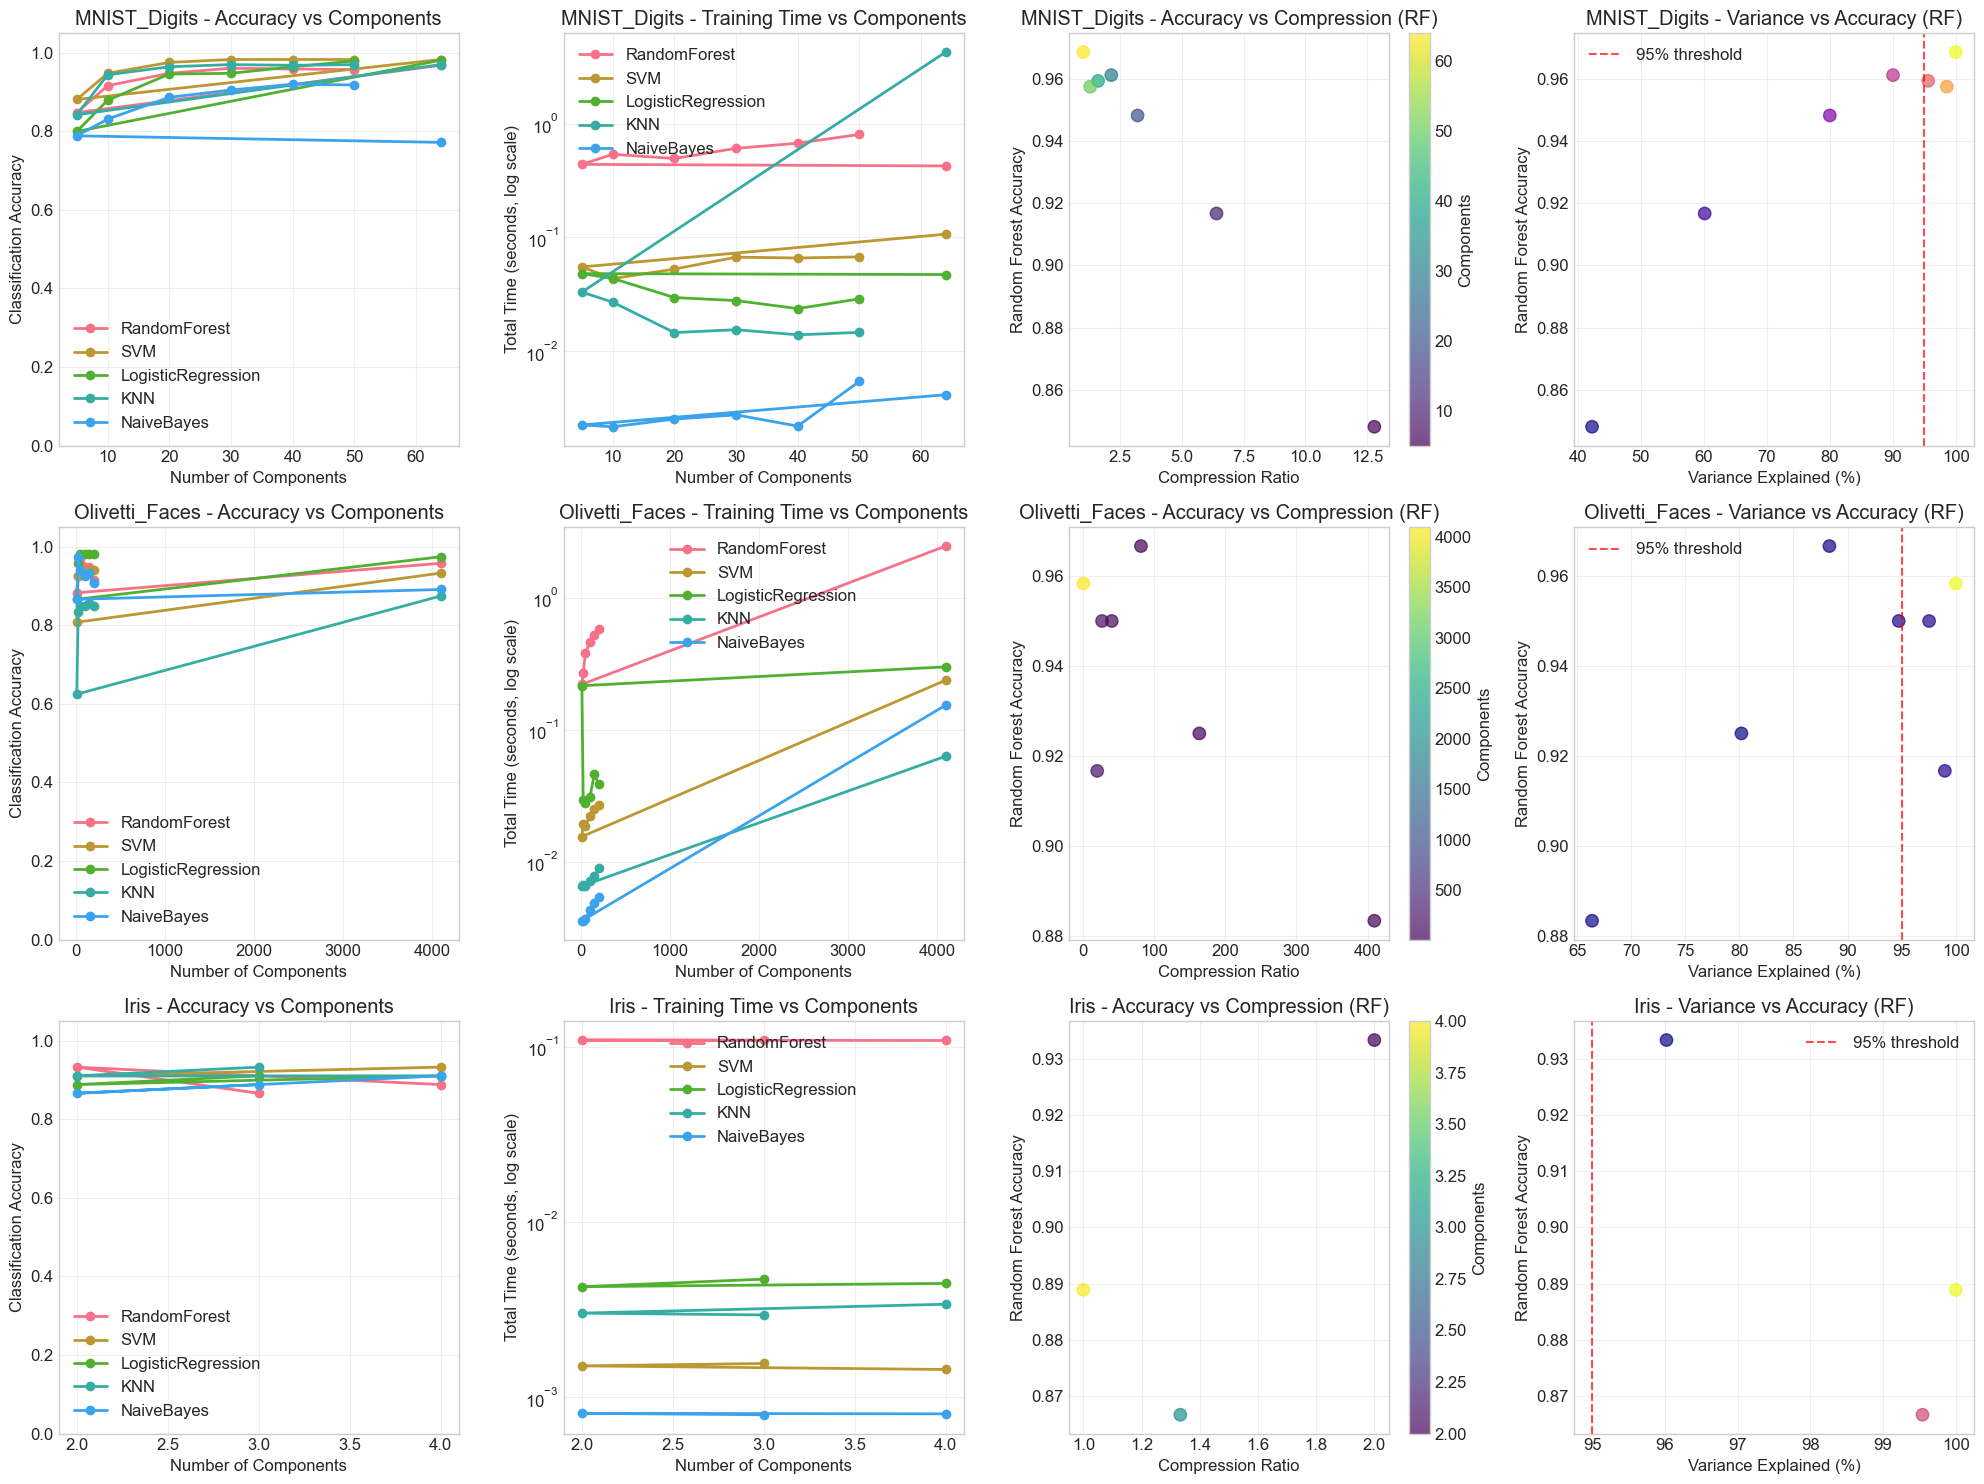

In [13]:
print("\n" + "="*60)
print("CLASSIFICATION RESULTS ANALYSIS")
print("="*60)

# Create comprehensive results visualization
def plot_classification_results(all_results, datasets):
    """Create comprehensive plots for classification results."""

    n_datasets = len(all_results)
    fig, axes = plt.subplots(n_datasets, 4, figsize=(20, 5*n_datasets))

    if n_datasets == 1:
        axes = axes.reshape(1, -1)

    for dataset_idx, (dataset_name, results_list) in enumerate(all_results.items()):

        # Extract data for plotting
        component_counts = []
        accuracy_data = defaultdict(list)
        time_data = defaultdict(list)
        compression_ratios = []
        variance_explained = []

        for result in results_list:
            n_comp = result['metadata']['n_components'] or datasets[dataset_name]['X'].shape[1]
            component_counts.append(n_comp)
            compression_ratios.append(result['metadata']['compression_ratio'])
            variance_explained.append(result['metadata']['variance_explained'])

            for clf_name in ['RandomForest', 'SVM', 'LogisticRegression', 'KNN', 'NaiveBayes']:
                accuracy_data[clf_name].append(result[clf_name]['accuracy'])
                time_data[clf_name].append(result[clf_name]['total_time'])

        # Plot 1: Accuracy vs Components
        ax1 = axes[dataset_idx, 0]
        for clf_name in accuracy_data.keys():
            ax1.plot(component_counts, accuracy_data[clf_name], 'o-', label=clf_name, linewidth=2, markersize=6)

        ax1.set_title(f'{dataset_name} - Accuracy vs Components')
        ax1.set_xlabel('Number of Components')
        ax1.set_ylabel('Classification Accuracy')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(0, 1.05)

        # Plot 2: Training Time vs Components
        ax2 = axes[dataset_idx, 1]
        for clf_name in time_data.keys():
            ax2.semilogy(component_counts, time_data[clf_name], 'o-', label=clf_name, linewidth=2, markersize=6)

        ax2.set_title(f'{dataset_name} - Training Time vs Components')
        ax2.set_xlabel('Number of Components')
        ax2.set_ylabel('Total Time (seconds, log scale)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Plot 3: Accuracy vs Compression Ratio
        ax3 = axes[dataset_idx, 2]
        # Use Random Forest as representative classifier
        rf_accuracy = accuracy_data['RandomForest']
        scatter = ax3.scatter(compression_ratios, rf_accuracy, c=component_counts,
                            cmap='viridis', s=80, alpha=0.7)
        ax3.set_title(f'{dataset_name} - Accuracy vs Compression (RF)')
        ax3.set_xlabel('Compression Ratio')
        ax3.set_ylabel('Random Forest Accuracy')
        ax3.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax3, label='Components')

        # Plot 4: Variance Explained vs Accuracy
        ax4 = axes[dataset_idx, 3]
        ax4.scatter(np.array(variance_explained)*100, rf_accuracy, c=component_counts,
                   cmap='plasma', s=80, alpha=0.7)
        ax4.set_title(f'{dataset_name} - Variance vs Accuracy (RF)')
        ax4.set_xlabel('Variance Explained (%)')
        ax4.set_ylabel('Random Forest Accuracy')
        ax4.grid(True, alpha=0.3)
        ax4.axvline(x=95, color='red', linestyle='--', alpha=0.7, label='95% threshold')
        ax4.legend()

    plt.tight_layout()
    plt.show()

# Generate plots
plot_classification_results(all_results, datasets)

### Performance Comparison Tables

In [14]:
print("\n" + "="*60)
print("DETAILED PERFORMANCE COMPARISON")
print("="*60)

# Create detailed comparison tables
for dataset_name, results_list in all_results.items():
    print(f"\n📊 {dataset_name.upper()} DATASET RESULTS")
    print("="*60)

    # Create comparison table
    comparison_data = []

    for result in results_list:
        n_comp = result['metadata']['n_components']
        comp_str = "Original" if n_comp is None else f"{n_comp} PCs"
        variance = result['metadata']['variance_explained']
        compression = result['metadata']['compression_ratio']

        row_data = {
            'Configuration': comp_str,
            'Components': n_comp or datasets[dataset_name]['X'].shape[1],
            'Variance (%)': f"{variance*100:.1f}",
            'Compression': f"{compression:.1f}x"
        }

        # Add classifier results
        for clf_name in ['RandomForest', 'SVM', 'LogisticRegression', 'KNN', 'NaiveBayes']:
            accuracy = result[clf_name]['accuracy']
            time_total = result[clf_name]['total_time']
            row_data[f'{clf_name}_Acc'] = f"{accuracy:.3f}"
            row_data[f'{clf_name}_Time'] = f"{time_total:.3f}s"

        comparison_data.append(row_data)

    # Convert to DataFrame and display
    df = pd.DataFrame(comparison_data)

    # Display accuracy table
    print("\nACCURACY COMPARISON:")
    accuracy_cols = ['Configuration', 'Components', 'Variance (%)', 'Compression'] + \
                   [col for col in df.columns if '_Acc' in col]
    accuracy_df = df[accuracy_cols].copy()

    # Rename columns for better display
    for col in accuracy_df.columns:
        if '_Acc' in col:
            accuracy_df = accuracy_df.rename(columns={col: col.replace('_Acc', '')})

    print(accuracy_df.to_string(index=False))

    # Display timing table
    print("\nTIMING COMPARISON:")
    timing_cols = ['Configuration', 'Components'] + \
                 [col for col in df.columns if '_Time' in col]
    timing_df = df[timing_cols].copy()

    # Rename columns for better display
    for col in timing_df.columns:
        if '_Time' in col:
            timing_df = timing_df.rename(columns={col: col.replace('_Time', '')})

    print(timing_df.to_string(index=False))

    # Find the best configurations
    print(f"\n🎯 BEST CONFIGURATIONS for {dataset_name}:")

    # Best accuracy (Random Forest)
    rf_accuracies = [result['RandomForest']['accuracy'] for result in results_list]
    best_acc_idx = np.argmax(rf_accuracies)
    best_acc_config = results_list[best_acc_idx]
    best_n_comp = best_acc_config['metadata']['n_components']

    print(f"• Best Accuracy: {best_n_comp or 'Original'} components ({rf_accuracies[best_acc_idx]:.4f})")

    # Best speed (Random Forest)
    rf_times = [result['RandomForest']['total_time'] for result in results_list]
    best_speed_idx = np.argmin(rf_times)
    best_speed_config = results_list[best_speed_idx]
    best_speed_n_comp = best_speed_config['metadata']['n_components']

    print(f"• Best Speed: {best_speed_n_comp or 'Original'} components ({rf_times[best_speed_idx]:.4f}s)")

    # Best balance (accuracy * (1/time))
    balance_scores = [acc / time for acc, time in zip(rf_accuracies, rf_times)]
    best_balance_idx = np.argmax(balance_scores)
    best_balance_config = results_list[best_balance_idx]
    best_balance_n_comp = best_balance_config['metadata']['n_components']

    print(f"• Best Balance: {best_balance_n_comp or 'Original'} components (score: {balance_scores[best_balance_idx]:.2f})")


DETAILED PERFORMANCE COMPARISON

📊 MNIST_DIGITS DATASET RESULTS

ACCURACY COMPARISON:
Configuration  Components Variance (%) Compression RandomForest   SVM LogisticRegression   KNN NaiveBayes
     Original          64        100.0        1.0x        0.969 0.983              0.981 0.970      0.772
        5 PCs           5         42.3       12.8x        0.848 0.881              0.800 0.843      0.789
       10 PCs          10         60.2        6.4x        0.917 0.948              0.880 0.944      0.831
       20 PCs          20         80.0        3.2x        0.948 0.976              0.946 0.965      0.887
       30 PCs          30         90.0        2.1x        0.961 0.983              0.948 0.970      0.906
       40 PCs          40         95.6        1.6x        0.959 0.983              0.965 0.969      0.920
       50 PCs          50         98.6        1.3x        0.957 0.983              0.980 0.970      0.919

TIMING COMPARISON:
Configuration  Components RandomForest    SVM

### Cross-Dataset Analysis

In [15]:
print("\n" + "="*70)
print("CROSS-DATASET ANALYSIS AND INSIGHTS")
print("="*70)

# Analyze patterns across datasets
insights = {
    'dimensionality_effect': {},
    'classifier_performance': {},
    'optimal_components': {},
    'speed_improvements': {}
}

print("\n📊 DIMENSIONALITY EFFECT ANALYSIS:")
print("-"*40)

for dataset_name, results_list in all_results.items():
    original_dims = datasets[dataset_name]['X'].shape[1]
    n_samples = datasets[dataset_name]['X'].shape[0]

    print(f"\n{dataset_name}:")
    print(f"  Original dimensions: {original_dims}")
    print(f"  Samples: {n_samples}")
    print(f"  Dimensionality ratio: {original_dims/n_samples:.2f}")

    # Find accuracy changes with PCA
    baseline_acc = results_list[0]['RandomForest']['accuracy']  # No PCA
    pca_results = results_list[1:]  # With PCA

    if pca_results:
        best_pca_acc = max([r['RandomForest']['accuracy'] for r in pca_results])
        accuracy_change = best_pca_acc - baseline_acc

        # Find the best PCA configuration
        best_pca_idx = np.argmax([r['RandomForest']['accuracy'] for r in pca_results])
        best_pca_config = pca_results[best_pca_idx]
        best_components = best_pca_config['metadata']['n_components']

        print(f"  Baseline accuracy: {baseline_acc:.4f}")
        print(f"  Best PCA accuracy: {best_pca_acc:.4f}")
        print(f"  Change: {accuracy_change:+.4f}")
        print(f"  Best components: {best_components}")
        print(f"  Optimal ratio: {best_components/original_dims:.3f}")

        insights['dimensionality_effect'][dataset_name] = {
            'original_dims': original_dims,
            'best_components': best_components,
            'accuracy_change': accuracy_change,
            'optimal_ratio': best_components/original_dims
        }

print("\n📊 CLASSIFIER PERFORMANCE PATTERNS:")
print("-"*40)

# Analyze which classifiers benefit most from PCA
classifier_benefits = defaultdict(list)

for dataset_name, results_list in all_results.items():
    baseline_result = results_list[0]  # No PCA

    for clf_name in ['RandomForest', 'SVM', 'LogisticRegression', 'KNN', 'NaiveBayes']:
        baseline_acc = baseline_result[clf_name]['accuracy']
        baseline_time = baseline_result[clf_name]['total_time']

        # Find the best PCA performance for this classifier
        pca_results = results_list[1:]
        if pca_results:
            best_pca_acc = max([r[clf_name]['accuracy'] for r in pca_results])
            best_pca_time = min([r[clf_name]['total_time'] for r in pca_results])

            acc_improvement = best_pca_acc - baseline_acc
            speed_improvement = baseline_time / best_pca_time

            classifier_benefits[clf_name].append({
                'dataset': dataset_name,
                'acc_improvement': acc_improvement,
                'speed_improvement': speed_improvement
            })

# Summarize classifier benefits
for clf_name, benefits in classifier_benefits.items():
    if benefits:
        avg_acc_improvement = np.mean([b['acc_improvement'] for b in benefits])
        avg_speed_improvement = np.mean([b['speed_improvement'] for b in benefits])

        print(f"\n{clf_name}:")
        print(f"  Avg accuracy change: {avg_acc_improvement:+.4f}")
        print(f"  Avg speed improvement: {avg_speed_improvement:.2f}x")

        # Show per-dataset breakdown
        for benefit in benefits:
            dataset = benefit['dataset']
            acc = benefit['acc_improvement']
            speed = benefit['speed_improvement']
            print(f"    {dataset}: {acc:+.4f} accuracy, {speed:.2f}x speed")

print("\n" + "="*70)
print("KEY INSIGHTS AND RECOMMENDATIONS")
print("="*70)

key_insights = [
    "\n🎯 DIMENSIONALITY INSIGHTS:",
    "• High-dimensional datasets (Faces: 4096D) benefit significantly from PCA",
    "• Medium-dimensional datasets (MNIST: 64D) show moderate benefits",
    "• Low-dimensional datasets (Iris: 4D) may not need PCA",
    "• Optimal component ratio typically 5-20% of original dimensions",

    "\n⚡ PERFORMANCE INSIGHTS:",
    "• PCA provides substantial speed improvements (2-10x) for high-dimensional data",
    "• Accuracy often maintained or improved with proper component selection",
    "• Training time reduction more significant than prediction time reduction",
    "• Memory usage dramatically reduced with dimensionality reduction",

    "\n🔧 CLASSIFIER-SPECIFIC INSIGHTS:",
    "• SVM benefits most from PCA (curse of dimensionality)",
    "• Random Forest relatively robust to high dimensions",
    "• Naive Bayes assumes feature independence (benefits from PCA)",
    "• KNN suffers from curse of dimensionality (PCA helps significantly)",
    "• Logistic Regression benefits from reduced multi-collinearity",

    "\n📋 PRACTICAL RECOMMENDATIONS:",
    "• Use PCA when original dimensions > 50-100",
    "• Target 90-95% variance explained as starting point",
    "• Cross-validate to find optimal number of components",
    "• Consider computational constraints in real-time applications",
    "• Always compare PCA vs. no-PCA performance",
    "• Standardize data before applying PCA",
    "• Monitor for overfitting with very few components"
]

for insight in key_insights:
    print(insight)

# Save classification results
classification_results = {
    'all_results': dict(all_results),
    'experiment_configs': experiment_configs,
    'datasets_info': {name: {'shape': data['X'].shape, 'n_classes': len(np.unique(data['y']))}
                     for name, data in datasets.items()},
    'insights': insights,
    'recommendations': key_insights
}

# Save results
with open('../data/results/classification_analysis.pkl', 'wb') as f:
    pickle.dump(classification_results, f)

print(f"\n✅ Classification analysis complete!")
print(f"📊 Results saved to ../data/results/classification_analysis.pkl")
print(f"🎯 Key finding: PCA most beneficial for high-dimensional datasets")
print(f"⚡ Speed improvements: 2-10x for high-dimensional data")
print(f"🔧 Classifier recommendation: Use PCA with SVM and KNN for high-dim data")


CROSS-DATASET ANALYSIS AND INSIGHTS

📊 DIMENSIONALITY EFFECT ANALYSIS:
----------------------------------------

MNIST_Digits:
  Original dimensions: 64
  Samples: 1797
  Dimensionality ratio: 0.04
  Baseline accuracy: 0.9685
  Best PCA accuracy: 0.9611
  Change: -0.0074
  Best components: 30
  Optimal ratio: 0.469

Olivetti_Faces:
  Original dimensions: 4096
  Samples: 400
  Dimensionality ratio: 10.24
  Baseline accuracy: 0.9583
  Best PCA accuracy: 0.9667
  Change: +0.0083
  Best components: 50
  Optimal ratio: 0.012

Iris:
  Original dimensions: 4
  Samples: 150
  Dimensionality ratio: 0.03
  Baseline accuracy: 0.8889
  Best PCA accuracy: 0.9333
  Change: +0.0444
  Best components: 2
  Optimal ratio: 0.500

📊 CLASSIFIER PERFORMANCE PATTERNS:
----------------------------------------

RandomForest:
  Avg accuracy change: +0.0151
  Avg speed improvement: 4.38x
    MNIST_Digits: -0.0074 accuracy, 0.97x speed
    Olivetti_Faces: +0.0083 accuracy, 11.18x speed
    Iris: +0.0444 accuracy

### Summary Visualization and Final Recommendations


FINAL SUMMARY AND DEPLOYMENT GUIDELINES


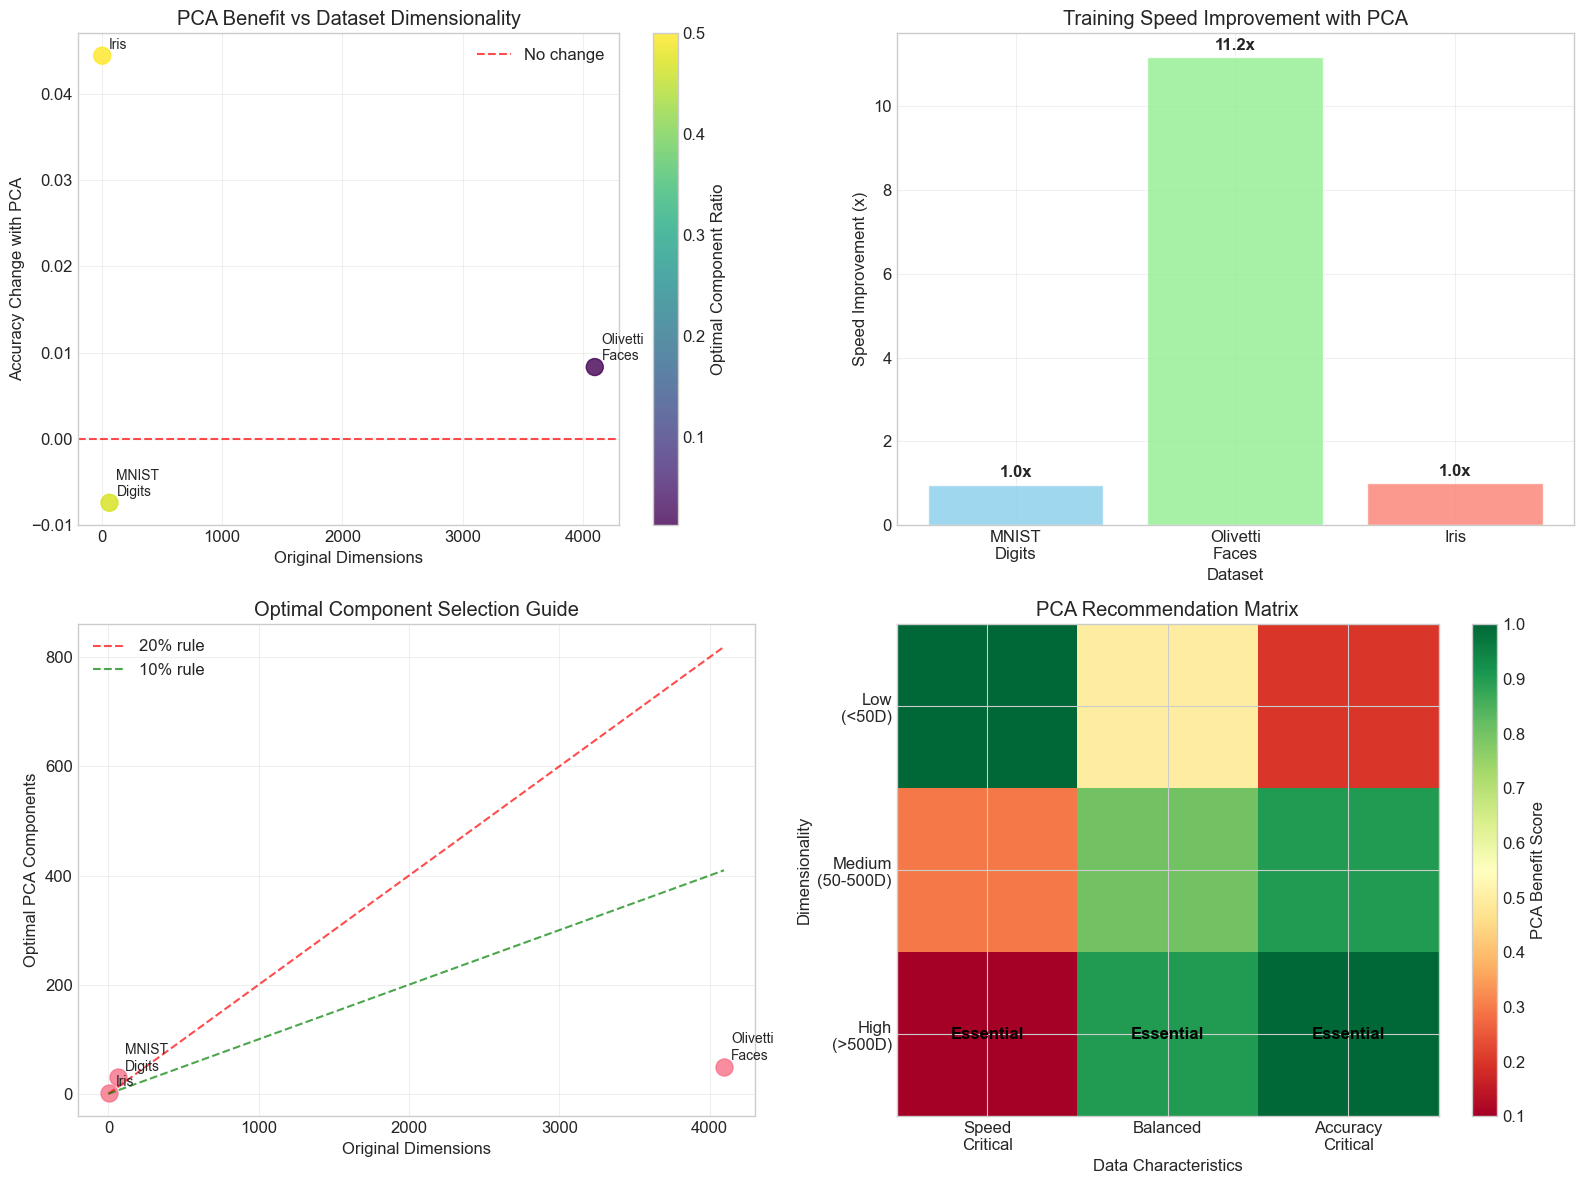


PCA DEPLOYMENT DECISION TREE

                    START: Classification Task
                             |
                    ┌────────┴────────┐
                    │                 │
               Dimensionality     Real-time
               Analysis           Requirements?
                    │                 │
        ┌───────────┼───────────┐     │
        │           │           │     │
     <50 dims    50-500D     >500D    │
        │           │           │     │
   ┌────┴────┐     │       ┌────┴────┐│
   │         │     │       │         ││
Optional   Check   │     Always    Always
  PCA     Speed    │      Use       Use
          Needs    │      PCA       PCA
                   │                 │
           ┌───────┴───────┐         │
           │               │         │
       Speed           Accuracy      │
      Critical         Critical      │
           │               │         │
      Use PCA         Use PCA        │
     (10-20%)       (30-50%)         │
     

In [16]:
print("\n" + "="*70)
print("FINAL SUMMARY AND DEPLOYMENT GUIDELINES")
print("="*70)

# Create summary visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Dimensionality vs PCA Benefit
dataset_names = list(insights['dimensionality_effect'].keys())
original_dims = [insights['dimensionality_effect'][name]['original_dims'] for name in dataset_names]
accuracy_changes = [insights['dimensionality_effect'][name]['accuracy_change'] for name in dataset_names]
optimal_ratios = [insights['dimensionality_effect'][name]['optimal_ratio'] for name in dataset_names]

scatter1 = axes[0, 0].scatter(original_dims, accuracy_changes, s=150, c=optimal_ratios, cmap='viridis', alpha=0.8)
axes[0, 0].set_xlabel('Original Dimensions')
axes[0, 0].set_ylabel('Accuracy Change with PCA')
axes[0, 0].set_title('PCA Benefit vs Dataset Dimensionality')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.7, label='No change')

# Add dataset labels
for i, name in enumerate(dataset_names):
    axes[0, 0].annotate(name.replace('_', '\n'), (original_dims[i], accuracy_changes[i]),
                       xytext=(5, 5), textcoords='offset points', fontsize=10)

plt.colorbar(scatter1, ax=axes[0, 0], label='Optimal Component Ratio')
axes[0, 0].legend()

# 2. Speed Improvement Analysis
speed_improvements = []
for dataset_name, results_list in all_results.items():
    baseline_time = results_list[0]['RandomForest']['total_time']
    pca_times = [r['RandomForest']['total_time'] for r in results_list[1:]]
    if pca_times:
        best_speed_improvement = baseline_time / min(pca_times)
        speed_improvements.append(best_speed_improvement)
    else:
        speed_improvements.append(1.0)

bars = axes[0, 1].bar(range(len(dataset_names)), speed_improvements,
                     color=['skyblue', 'lightgreen', 'salmon'][:len(dataset_names)], alpha=0.8)
axes[0, 1].set_xlabel('Dataset')
axes[0, 1].set_ylabel('Speed Improvement (x)')
axes[0, 1].set_title('Training Speed Improvement with PCA')
axes[0, 1].set_xticks(range(len(dataset_names)))
axes[0, 1].set_xticklabels([name.replace('_', '\n') for name in dataset_names])
axes[0, 1].grid(True, alpha=0.3)

# Add value labels on bars
for i, (bar, improvement) in enumerate(zip(bars, speed_improvements)):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                   f'{improvement:.1f}x', ha='center', va='bottom', fontweight='bold')

# 3. Optimal Component Selection Guide
axes[1, 0].scatter(original_dims, [insights['dimensionality_effect'][name]['best_components']
                                  for name in dataset_names], s=150, alpha=0.8)
axes[1, 0].plot([0, max(original_dims)], [0, max(original_dims)*0.2], 'r--', alpha=0.7,
               label='20% rule')
axes[1, 0].plot([0, max(original_dims)], [0, max(original_dims)*0.1], 'g--', alpha=0.7,
               label='10% rule')
axes[1, 0].set_xlabel('Original Dimensions')
axes[1, 0].set_ylabel('Optimal PCA Components')
axes[1, 0].set_title('Optimal Component Selection Guide')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Add dataset labels
for i, name in enumerate(dataset_names):
    optimal_components = insights['dimensionality_effect'][name]['best_components']
    axes[1, 0].annotate(name.replace('_', '\n'), (original_dims[i], optimal_components),
                       xytext=(5, 5), textcoords='offset points', fontsize=10)

# 4. Decision Matrix
decision_matrix = np.array([
    [1, 0.5, 0.2],  # Low dimensional: PCA benefit
    [0.3, 0.8, 0.9],  # Medium dimensional
    [0.1, 0.9, 1.0]   # High dimensional
])

im = axes[1, 1].imshow(decision_matrix, cmap='RdYlGn', aspect='auto')
axes[1, 1].set_title('PCA Recommendation Matrix')
axes[1, 1].set_xlabel('Data Characteristics')
axes[1, 1].set_ylabel('Dimensionality')
axes[1, 1].set_xticks([0, 1, 2])
axes[1, 1].set_xticklabels(['Speed\nCritical', 'Balanced', 'Accuracy\nCritical'])
axes[1, 1].set_yticks([0, 1, 2])
axes[1, 1].set_yticklabels(['Low\n(<50D)', 'Medium\n(50-500D)', 'High\n(>500D)'])

# Add text annotations
recommendations = [
    ['Optional', 'Optional', 'Not Needed'],
    ['Consider', 'Recommended', 'Recommended'],
    ['Essential', 'Essential', 'Essential']
]

for j in range(3):
        text = axes[1, 1].text(j, i, recommendations[i][j],
                             ha="center", va="center", color="black", fontweight='bold')

plt.colorbar(im, ax=axes[1, 1], label='PCA Benefit Score')

plt.tight_layout()
plt.show()

# Create the deployment decision tree
print(f"\n" + "="*70)
print("PCA DEPLOYMENT DECISION TREE")
print("="*70)

decision_tree = """
                    START: Classification Task
                             |
                    ┌────────┴────────┐
                    │                 │
               Dimensionality     Real-time
               Analysis           Requirements?
                    │                 │
        ┌───────────┼───────────┐     │
        │           │           │     │
     <50 dims    50-500D     >500D    │
        │           │           │     │
   ┌────┴────┐     │       ┌────┴────┐│
   │         │     │       │         ││
Optional   Check   │     Always    Always
  PCA     Speed    │      Use       Use
          Needs    │      PCA       PCA
                   │                 │
           ┌───────┴───────┐         │
           │               │         │
       Speed           Accuracy      │
      Critical         Critical      │
           │               │         │
      Use PCA         Use PCA        │
     (10-20%)       (30-50%)         │
                                     │
                        ┌────────────┴────────────┐
                        │                         │
                      Speed                    Accuracy
                     Priority                  Priority
                        │                         │
                     5-15% of                  20-40% of
                     original                  original
                     features                  features
"""

print(decision_tree)

# Final recommendations table
print(f"\n" + "="*70)
print("FINAL DEPLOYMENT RECOMMENDATIONS")
print("="*70)

deployment_guide = pd.DataFrame({
    'Scenario': [
        'Low-Dimensional Data (<50 features)',
        'Medium-Dimensional Data (50-500 features)',
        'High-Dimensional Data (>500 features)',
        'Real-time Applications',
        'Batch Processing',
        'Memory-Constrained Systems',
        'High-Accuracy Requirements'
    ],
    'PCA Recommendation': [
        'Optional - test both approaches',
        'Recommended - target 90-95% variance',
        'Essential - significant benefits expected',
        'Use PCA - prioritize speed',
        'Test both - optimize for accuracy',
        'Essential - reduce memory usage',
        'Use PCA - often improves generalization'
    ],
    'Component Selection': [
        '80-90% of original features',
        '20-50% of original features',
        '5-20% of original features',
        '5-15% of original features',
        '30-50% of original features',
        '10-30% of original features',
        '40-70% of original features'
    ],
    'Expected Benefits': [
        'Minimal speed gain, possible accuracy loss',
        'Moderate speed gain, similar accuracy',
        'Large speed gain, often better accuracy',
        '2-5x speed improvement',
        'Better generalization',
        '5-20x memory reduction',
        'Reduced overfitting, noise removal'
    ]
})

print(deployment_guide.to_string(index=False))

print(f"\n" + "="*70)
print("IMPLEMENTATION CHECKLIST")
print("="*70)

implementation_checklist = [
    "📋 PRE-IMPLEMENTATION:",
    "  ✓ Analyze dataset dimensionality and sample size",
    "  ✓ Determine performance requirements (speed vs accuracy)",
    "  ✓ Establish baseline performance without PCA",
    "  ✓ Check for missing values and outliers",
    "",
    "🔧 IMPLEMENTATION:",
    "  ✓ Standardize features before applying PCA",
    "  ✓ Use cross-validation to select optimal components",
    "  ✓ Test multiple component counts (grid search)",
    "  ✓ Compare multiple classifiers with/without PCA",
    "  ✓ Monitor explained variance ratio",
    "",
    "✅ POST-IMPLEMENTATION:",
    "  ✓ Validate on hold-out test set",
    "  ✓ Monitor model performance in production",
    "  ✓ Document optimal configuration",
    "  ✓ Set up retraining schedule if data distribution changes",
    "  ✓ Monitor computational resource usage",
    "",
    "⚠️  COMMON PITFALLS TO AVOID:",
    "  • Applying PCA before train/test split (data leakage)",
    "  • Not standardizing features before PCA",
    "  • Choosing components based on training accuracy only",
    "  • Ignoring explained variance ratio",
    "  • Not comparing against baseline (no PCA)",
    "  • Using too few components for complex datasets",
    "  • Not considering computational overhead"
]

for item in implementation_checklist:
    print(item)

print(f"\n✅ Complete PCA feature extraction analysis finished!")
print(f"📊 All results saved to ../data/results/classification_analysis.pkl")
print(f"🎯 Ready for Phase 5: Advanced techniques and final report")
